# Assignment 06
#### Collaborators: Mauricio Bermudez, Alvaro Montoya Ruiz, Hriday Reddy Purma
#### Task: Multivariate Time Series Forecasting RNN model. Training and validation runs registry.

# Introduction

In this assignment, we are developing a forecasting model for a multivariate time series dataset. We will start by selecting a sequential dataset where at least two features are measured at equal time intervals. Our model will use past readings to predict a single output value at time t+1. To track our progress, we are integrating Weights & Biases (wandb) to log key training metrics, including MSE and MAE, as well as the network’s weights, biases, and gradients throughout the training process.

# 1. Importing Libraries and Setting the Device

We begin by importing libraries for numerical computations, plotting, neural network modeling with PyTorch, evaluation metrics, and wandb for experiment tracking. We then set the device based on CUDA availability.

In [1]:

import os
import wandb
import requests
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error
from retry_requests import retry
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# set repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)     # Set a random seed for CUDA operations.
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    
    # Ensure deterministic behavior for CUDA operations (note: If you are not concerned with reportable reproducibility, set deterministic to false, and benchmark to true - as it can choose faster algorithms).
    torch.backends.cudnn.deterministic = True  # Set cuDNN to deterministic mode - it will now only select algorithms that are known to be deterministic.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking - it may select the best algorithms for the hardware, but it doesn't guarantee deterministic results.   

Using device: cuda


## Dataset :
This study aims to analyze historical weather data for Tampa, Florida (latitude: 27.9475, longitude: -82.4584), spanning from March 14, 1990, to March 28, 2025. The dataset retrieved from the Open-Meteo Archive API includes hourly historical weather data covering a period of over three decades. The selected meteorological parameters include: 

* Temperature at 2 meters (temperature_2m): Measures the air temperature near the surface, influencing climate studies and agricultural planning. 
* Precipitation (precipitation): Includes rain and snow measurements, crucial for understanding weather patterns, hydrology, and flood risks. 
* Mean Sea Level Pressure (pressure_msl): An indicator of large-scale weather patterns, such as storm systems and high-pressure zones. 
* Surface Pressure (surface_pressure): Helps analyze local weather variations and their impact on atmospheric stability. 
* Relative Humidity at 2 meters (relative_humidity_2m): Essential for studying moisture content in the air, impacting comfort levels and cloud formation. 
* Wind Speed at 10 meters (wind_speed_10m): Provides insights into wind patterns, which influence aviation, maritime activities, and renewable energy generation. 

## Prepare Training set

In [2]:
# Column names for KDD 1999 dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]

# Load the dataset
txt_file_path = "kddcup_data.txt"  # Update with the correct file path
df = pd.read_csv(txt_file_path, names=column_names, sep=",", engine="python", on_bad_lines="skip")

# Filter normal traffic
df_normal = df[df["label"] == "normal."]
df_numeric_normal = df_normal.drop(columns=["protocol_type", "service", "flag","label"], errors='ignore')

# Print dataset length
print(f"Number of normal rows: {len(df_numeric_normal)}")

# Filter anomaly traffic
df_anomaly = df[df["label"] != "normal."]

# Extract up to 200K rows for neptune and smurf attacks
df_neptune = df_anomaly[df_anomaly["label"] == "neptune."].drop(columns=["protocol_type", "service", "flag","label"], errors='ignore').head(200000)
df_smurf = df_anomaly[df_anomaly["label"] == "smurf."].drop(columns=["protocol_type", "service", "flag","label"], errors='ignore').head(200000)

# Get all other attack types except neptune and smurf
df_other_attacks = df_anomaly[~df_anomaly["label"].isin(["neptune.", "smurf."])]
df_other_attacks = df_other_attacks.drop(columns=["protocol_type", "service", "flag","label"], errors='ignore')

# Print the number of records for each attack type
print(f"Neptune Attack Samples: {len(df_neptune)}")
print(f"Smurf Attack Samples: {len(df_smurf)}")
print(f"Other Attacks Samples: {len(df_other_attacks)}")


Number of normal rows: 972780
Neptune Attack Samples: 200000
Smurf Attack Samples: 200000
Other Attacks Samples: 45747


## Prepare Test set for mixed file

In [3]:


txt_file_path = "corrected.txt"  # Update with the correct file path
df_test = pd.read_csv(txt_file_path, names=column_names, sep=",", engine="python", on_bad_lines="skip")

# Drop categorical variables and label column
df_numeric_test = df_test.drop(columns=["protocol_type", "service", "flag","label"], errors='ignore')
# Drop categorical variables and label column

# Print dataset length
print(f"Number of normal rows: {len(df_numeric_test)}")
print(df_numeric_test.head())

Number of normal rows: 311029
   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        105        146     0               0       0    0   
1         0        105        146     0               0       0    0   
2         0        105        146     0               0       0    0   
3         0        105        146     0               0       0    0   
4         0        105        146     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  dst_host_count  \
0                  0          0                0  ...             255   
1                  0          0                0  ...             255   
2                  0          0                0  ...             255   
3                  0          0                0  ...             255   
4                  0          0                0  ...             255   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                 254    

# 3. Preprocessing steps :

Train-Validation-Test Split: 

To maintain the temporal integrity of weather data, a time-series split is implemented. The dataset is divided into: 

* 70% Training Set: Used to learn patterns in historical weather data. 
* 15% Validation Set: Used to fine-tune hyperparameters and avoid overfitting. 
* 15% Test Set: Used for final model evaluation to measure generalization performance. 

Data Normalization: 

Applying Min-Max scaling to transform all features into a range of [0,1] based on the training set’s statistics. This strategy helps to make sure that all the features are on the same scale, preventing any single variable from dominating the model. 

Sequence Creation: 

Since time series models require sequential input, we create overlapping sequences of length seq_len that serve as training samples. The target variable is the temperature at the end of each sequence. This allows the model to learn temporal dependencies effectively. 

Data Loader Preparation 

To enable efficient model training, we convert the NumPy arrays into PyTorch tensors and use the DataLoader class to manage batching and shuffling. This ensures that data is fed into the model in an optimized manner for parallel processing. 

In [4]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

In [5]:
# Read the API key from the text file
with open('API_KEY.txt', 'r') as file:
    wandb_api_key = file.read().strip()

if wandb_api_key:
    wandb.login(key=wandb_api_key)
else:
    raise ValueError("WANDB_API_KEY not found in API_KEY.txt!")

# Initialize wandb project
wandb.init(project="Assignment7", entity="usf-magma", config={
    "learning_rate": 0.0005,
    "dropout": 0.4,
    "batch_size": 64,
    "epochs": 20,
    "momentum": (0.9, 0.92),
    "weight_decay": 1e-5,
    "optimizer": "Adam",
    "criterion": "MSE",
    "sequence_length":15,
    "num_layers":4,
    "hidden_size": 18

})

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Gonax133\_netrc
wandb: Currently logged in as: montoyaruiz (usf-magma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, save_dir,device):
    
    model.to(device)  # Move model to device (CPU/GPU)
    train_losses = []


    for epoch in range(num_epochs):
        running_loss = 0.0

        for sequences in train_loader:
            sequences = sequences.to(device)

            optimizer.zero_grad()
            reconstructions = model(sequences)
            loss = criterion(reconstructions, sequences)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
            optimizer.step()

            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

        # Save model checkpoint
        torch.save(model.state_dict(), os.path.join(save_dir, f"rae_epoch_{epoch+1}.pth"))
        wandb.log({
            "Train Loss": train_losses,
        })
    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
    plt.title("Recurrent Autoencoder Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average MSE Loss")
    plt.grid(True)
    plt.show()
    

    return model


In [7]:

def evaluate_model_mix(model, test_loader, device):
    """Evaluate the model on the test set and plot Actual vs Prediction."""
    model.to(device)  # Ensure model is on the correct device
    model.eval() # Set model to evaluation mode

    all_sequences_np = []
    all_reconstructions_np = []

    print("Gathering reconstructions for the entire test set...")
    # Loop through the entire test loader
    with torch.no_grad():
        for sequences in test_loader:
            sequences = sequences.to(device)
            reconstructions = model(sequences)

            all_sequences_np.append(sequences.cpu().numpy())
            all_reconstructions_np.append(reconstructions.cpu().numpy())

    all_sequences_np = np.concatenate(all_sequences_np, axis=0)
    all_reconstructions_np = np.concatenate(all_reconstructions_np, axis=0)

     # Compute reconstruction errors
    reconstruction_errors = np.mean((all_sequences_np - all_reconstructions_np) ** 2, axis=(1, 2))
    threshold = np.percentile(reconstruction_errors, 95)  # Define anomaly threshold

    normal_errors = reconstruction_errors[reconstruction_errors <= threshold]
    anomaly_errors = reconstruction_errors[reconstruction_errors > threshold]

    # Plot error distribution
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(normal_errors, bins=50, color="blue", alpha=0.6, label="Normal Data", kde=True)
    sns.histplot(anomaly_errors, bins=50, color="red", alpha=0.6, label="Anomalies", kde=True)
    plt.axvline(threshold, color='black', linestyle='--', label="Threshold")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Count")
    plt.title("Histogram of Reconstruction Errors")
    plt.legend()

    # Density Plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(normal_errors, color="blue", label="Normal Data", fill=True)
    sns.kdeplot(anomaly_errors, color="red", label="Anomalies", fill=True)
    plt.axvline(threshold, color='black', linestyle='--', label="Threshold")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Density")
    plt.title("Density Plot of Reconstruction Errors")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Average Test Set Reconstruction MSE Loss: {np.mean(reconstruction_errors):.6f}")

    return reconstruction_errors

In [8]:
def get_reconstruction_errors(model, dataloader, device):
    """Calculates per-sample reconstruction error for sequential data (e.g., LSTM Autoencoder)."""
    model.to(device)
    model.eval()
    errors = []

    with torch.no_grad():
        for sequences in dataloader:
            sequences = sequences.to(device)

            # Forward pass through the model
            reconstructions = model(sequences)
            mse = torch.mean((sequences - reconstructions) ** 2, dim=(1, 2))  # shape: (batch_size,)

            errors.extend(mse.cpu().numpy())

    return np.array(errors)

In [9]:
def plot_error_distribution(normal_errors, anomaly_errors, dataset_names=("Normal", "Anomaly")):
    """Plots the distribution of reconstruction errors for normal and anomaly data, with better balance handling."""

    # Downsample normal data for plotting if necessary
    if len(normal_errors) > 5 * len(anomaly_errors):
        plot_normal_errors = np.random.choice(normal_errors, size=len(anomaly_errors)*3, replace=False)
    else:
        plot_normal_errors = normal_errors

    # Create DataFrames for plotting (keep full for stats, sampled for plot)
    df_normal_plot = pd.DataFrame({'error': plot_normal_errors, 'type': dataset_names[0]})
    df_anomaly_plot = pd.DataFrame({'error': anomaly_errors, 'type': dataset_names[1]})
    error_df_plot = pd.concat([df_normal_plot, df_anomaly_plot])

    # --- X-axis limit with margin ---
    x_max = max(np.percentile(normal_errors, 99.5), np.percentile(anomaly_errors, 99.5))
    x_max += 0.01  # Small buffer to avoid clipping

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("viridis", 2)
    
    sns.histplot(
        data=error_df_plot,
        x='error',
        hue='type',
        kde=True,
        bins=50,
        palette=palette,
        alpha=0.7,
        stat="density"  # Normalize
    )

    plt.xlim(0, x_max)
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Reconstruction Error (MSE per Sample)')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.5)

    custom_lines = [Line2D([0], [0], color=palette[0], lw=4),
                    Line2D([0], [0], color=palette[1], lw=4)]
    plt.legend(custom_lines, dataset_names, title="Data Type")

    plt.show()

    # --- Full Error Statistics ---
    print(f"\n📊 Error Statistics:")
    print(f"📌 {dataset_names[0]} Mean Error: {np.mean(normal_errors):.4f}")
    print(f"📌 {dataset_names[0]} Median Error: {np.median(normal_errors):.4f}")
    print(f"📌 {dataset_names[0]} 95th Percentile Error: {np.percentile(normal_errors, 95):.4f}")
    
    print(f"\n⚠️ {dataset_names[1]} Mean Error: {np.mean(anomaly_errors):.4f}")
    print(f"⚠️ {dataset_names[1]} Median Error: {np.median(anomaly_errors):.4f}")
    print(f"⚠️ {dataset_names[1]} 5th Percentile Error: {np.percentile(anomaly_errors, 5):.4f}")

# 4. Model Achitecture multiheaded RNN :

The Multiheaded RNN model, instead of processing all weather attributes through a single RNN, utilizes six independent RNNs, each dedicated to one weather feature. This multi-head approach allows each RNN to specialize in extracting temporal dependencies specific to its assigned weather attribute. Each independent RNN consists of a single layer with config.hidden_size (which is 64) recurrent units. These RNNs are well-suited for handling sequential dependencies across the different weather features. 

In [10]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, num_features, hidden_size, num_layers):
        super(RecurrentAutoencoder, self).__init__()

        self.seq_len = seq_len
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Encoder
        self.lstm_encoder = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Decoder
        self.lstm_decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Output Layer
        self.output_layer = nn.Linear(hidden_size, num_features)

    def forward(self, x):
        _, (hidden_state, cell_state) = self.lstm_encoder(x)
        decoder_input_tensor = hidden_state[-1].unsqueeze(1).repeat(1, self.seq_len, 1)
        decoder_outputs, _ = self.lstm_decoder(decoder_input_tensor, (hidden_state, cell_state))
        reconstructions = self.output_layer(decoder_outputs)
        return reconstructions


In [11]:
def preprocess_data(df_train, df_test_set, df_test_set_lim, df_numeric_test, df_neptune, df_smurf, df_other_attacks, config):


    # Initialize and fit the scaler
    scaler = MinMaxScaler()
    df_train_scaled = scaler.fit_transform(df_train)
    df_test_set_scaled = scaler.transform(df_test_set)
    df_test_set_lim_scaled = scaler.transform(df_test_set_lim)
    df_test_mix_scaled = scaler.transform(df_numeric_test)
    df_neptune_scaled = scaler.transform(df_neptune)
    df_smurf_scaled = scaler.transform(df_smurf)
    df_other_anomalies_scaled = scaler.transform(df_other_attacks)

    # Save scaler for reuse
    np.save("scaler.npy", scaler)

    # Create sequences
    X = create_sequences(df_train_scaled, config.sequence_length)
    X_test_normal = create_sequences(df_test_set_scaled, config.sequence_length)
    X_test_normal_lim = create_sequences(df_test_set_lim_scaled, config.sequence_length)
    X_test_mix = create_sequences(df_test_mix_scaled, config.sequence_length)
    X_neptune = create_sequences(df_neptune_scaled, config.sequence_length)
    X_smurf = create_sequences(df_smurf_scaled, config.sequence_length)
    X_other_anomalies = create_sequences(df_other_anomalies_scaled, config.sequence_length)

    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    X_test_tensor_normal = torch.tensor(X_test_normal, dtype=torch.float32)
    X_test_tensor_normal_lim = torch.tensor(X_test_normal_lim, dtype=torch.float32)
    X_test_tensor_mix = torch.tensor(X_test_mix, dtype=torch.float32)
    X_neptune_tensor = torch.tensor(X_neptune, dtype=torch.float32)
    X_smurf_tensor = torch.tensor(X_smurf, dtype=torch.float32)
    X_other_anomalies_tensor = torch.tensor(X_other_anomalies, dtype=torch.float32)

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(X_tensor, batch_size=config.batch_size, shuffle=True)
    test_loader_normal = torch.utils.data.DataLoader(X_test_tensor_normal, batch_size=config.batch_size, shuffle=False)
    test_loader_normal_lim = torch.utils.data.DataLoader(X_test_tensor_normal_lim, batch_size=config.batch_size, shuffle=False)
    test_loader_mix = torch.utils.data.DataLoader(X_test_tensor_mix, batch_size=config.batch_size, shuffle=False)
    test_loader_neptune = torch.utils.data.DataLoader(X_neptune_tensor, batch_size=config.batch_size, shuffle=False)
    test_loader_smurf = torch.utils.data.DataLoader(X_smurf_tensor, batch_size=config.batch_size, shuffle=False)
    test_loader_anomaly = torch.utils.data.DataLoader(X_other_anomalies_tensor, batch_size=config.batch_size, shuffle=False)

    return (
        train_loader,
        test_loader_normal,
        test_loader_normal_lim,
        test_loader_mix,
        test_loader_neptune,
        test_loader_smurf,
        test_loader_anomaly,
        X.shape[2]  # num_features
    )

Using device: cuda

Loader batch shape: torch.Size([64, 15, 38])
Epoch [1/20], Loss: 0.004915
Epoch [2/20], Loss: 0.002806
Epoch [3/20], Loss: 0.002558
Epoch [4/20], Loss: 0.002368
Epoch [5/20], Loss: 0.002243
Epoch [6/20], Loss: 0.002148
Epoch [7/20], Loss: 0.002061
Epoch [8/20], Loss: 0.001995
Epoch [9/20], Loss: 0.001950
Epoch [10/20], Loss: 0.001909
Epoch [11/20], Loss: 0.001865
Epoch [12/20], Loss: 0.001837
Epoch [13/20], Loss: 0.001816
Epoch [14/20], Loss: 0.001794
Epoch [15/20], Loss: 0.001773
Epoch [16/20], Loss: 0.001744
Epoch [17/20], Loss: 0.001717
Epoch [18/20], Loss: 0.001696
Epoch [19/20], Loss: 0.001683
Epoch [20/20], Loss: 0.001673


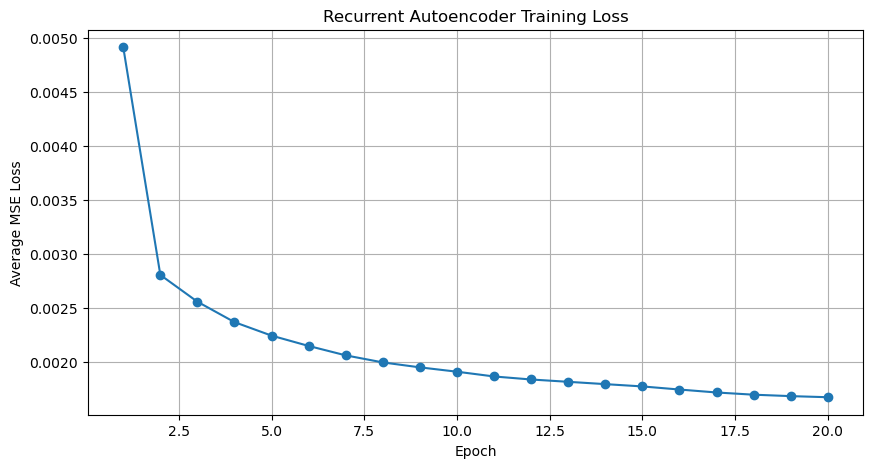

Gathering reconstructions for the entire test set...


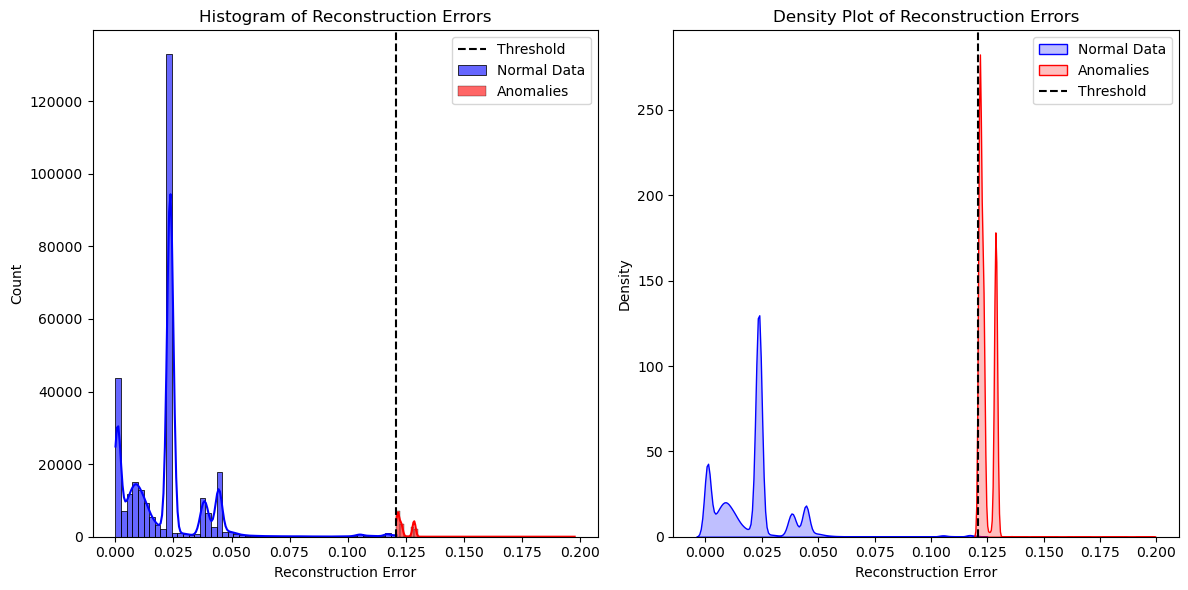

Average Test Set Reconstruction MSE Loss: 0.026456
Evaluating on normal test data...
Evaluating on normal test data limited...
Evaluating on anomaly test data...
Evaluating on neptune test data...
Evaluating on smurf test data...


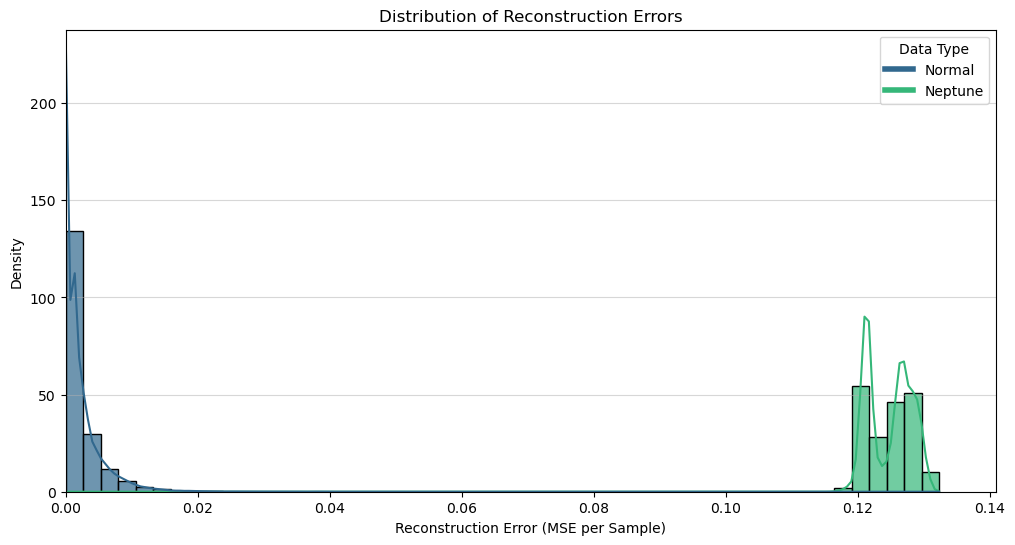


📊 Error Statistics:
📌 Normal Mean Error: 0.0023
📌 Normal Median Error: 0.0013
📌 Normal 95th Percentile Error: 0.0084

⚠️ Neptune Mean Error: 0.1248
⚠️ Neptune Median Error: 0.1256
⚠️ Neptune 5th Percentile Error: 0.1203


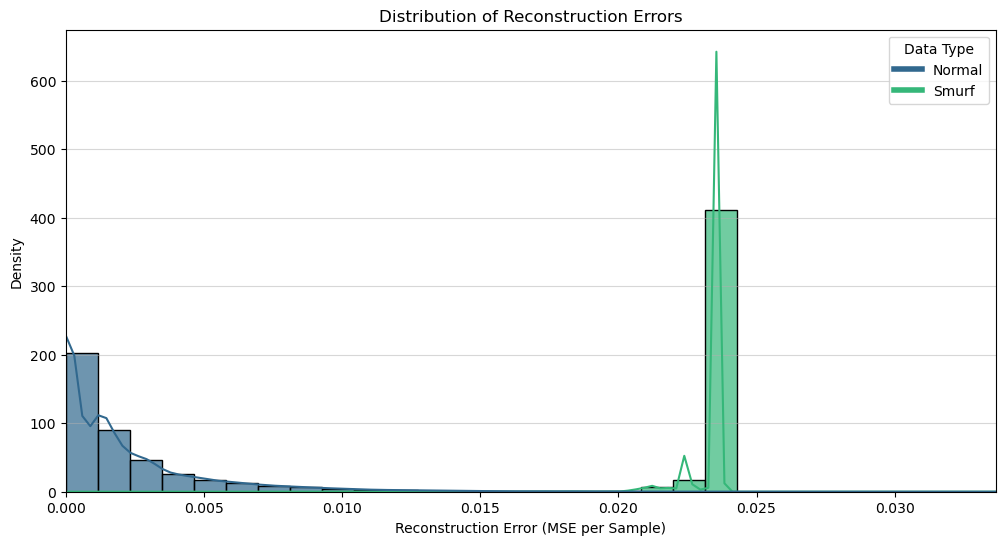


📊 Error Statistics:
📌 Normal Mean Error: 0.0023
📌 Normal Median Error: 0.0013
📌 Normal 95th Percentile Error: 0.0084

⚠️ Smurf Mean Error: 0.0235
⚠️ Smurf Median Error: 0.0237
⚠️ Smurf 5th Percentile Error: 0.0225


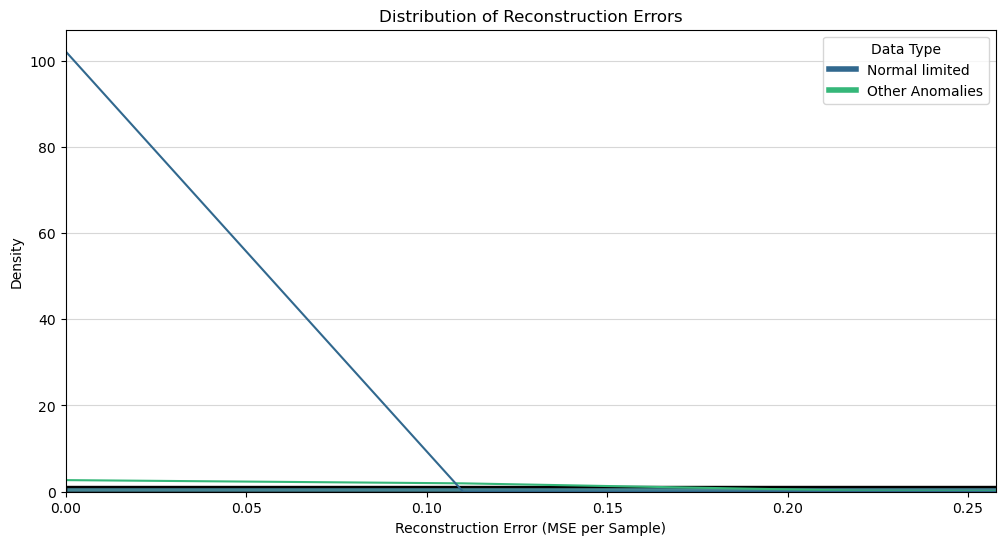


📊 Error Statistics:
📌 Normal limited Mean Error: 0.0028
📌 Normal limited Median Error: 0.0017
📌 Normal limited 95th Percentile Error: 0.0094

⚠️ Other Anomalies Mean Error: 0.0631
⚠️ Other Anomalies Median Error: 0.0240
⚠️ Other Anomalies 5th Percentile Error: 0.0016


In [12]:
if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create folder for saving models
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    # 80-20 time-based split
    split_index = int(len(df_numeric_normal) * 0.8)
    df_train = df_numeric_normal.iloc[:split_index]
    df_test_set = df_numeric_normal.iloc[split_index:]

    # Limit df_test_set to 40k rows
    df_test_set_lim = df_test_set.iloc[:40000]

    # Preprocess all data
    (
        train_loader,
        test_loader_normal,
        test_loader_normal_lim,
        test_loader_mix,
        test_loader_neptune,
        test_loader_smurf,
        test_loader_anomaly,
        num_features
    ) = preprocess_data(df_train, df_test_set, df_test_set_lim,df_numeric_test, df_neptune, df_smurf, df_other_attacks, config)

    # Sanity check
    sample_batch = next(iter(train_loader))
    print(f"\nLoader batch shape: {sample_batch.shape}")

    # Initialize model, loss, optimizer
    model = RecurrentAutoencoder(
        seq_len=config.sequence_length,
        num_features=num_features,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # Train
    model = train_model(model, train_loader, criterion, optimizer, config.epochs, save_dir, device)

    # Evaluate
    test_loss = evaluate_model_mix(model, test_loader_mix, device)

    print("Evaluating on normal test data...")
    normal_errors = get_reconstruction_errors(model, test_loader_normal, device)

    print("Evaluating on normal test data limited...")
    normal_errors_lim = get_reconstruction_errors(model, test_loader_normal_lim, device)
    print("Evaluating on anomaly test data...")
    anomaly_errors = get_reconstruction_errors(model, test_loader_anomaly, device)
    print("Evaluating on neptune test data...")
    anomaly_neptune = get_reconstruction_errors(model, test_loader_neptune, device)
    print("Evaluating on smurf test data...")
    anomaly_smurf = get_reconstruction_errors(model, test_loader_smurf, device)

    plot_error_distribution(normal_errors, anomaly_neptune, dataset_names=("Normal", "Neptune"))
    plot_error_distribution(normal_errors, anomaly_smurf, dataset_names=("Normal", "Smurf"))
    plot_error_distribution(normal_errors_lim, anomaly_errors, dataset_names=("Normal limited", "Other Anomalies"))

    wandb.finish()